# 1. Preparando el entorno

## Importar librerías

In [99]:
import pandas as pd

## 1.1. Dataset

In [100]:
df = pd.read_csv('dataset/IMDB Dataset.csv')
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


La idea es que nuestro input va a ser el comentario y el output el sentimiento, se van a usar 10000 de estos datos, desbalanceados para aprender como balancearlos luego

In [101]:
df_positivo = df[df["sentiment"]== "positive"][:9000]
df_negativo = df[df["sentiment"]== "negative"][:1000]

df_desbalanced = pd.concat([df_positivo, df_negativo])
df_desbalanced

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
...,...,...
2000,Stranded in Space (1972) MST3K version - a ver...,negative
2005,"I happened to catch this supposed ""horror"" fli...",negative
2007,waste of 1h45 this nasty little film is one to...,negative
2010,Warning: This could spoil your movie. Watch it...,negative


Verificar que tengamos la cantidad necesaria

In [102]:
df_desbalanced.value_counts("sentiment")

sentiment
positive    9000
negative    1000
Name: count, dtype: int64

## 1.2. Balancear el dataset

over_sampling: Aumentar los datos <br>
under_sampling: Disminuir los datos

In [103]:
from imblearn.under_sampling import RandomUnderSampler

In [104]:
rus = RandomUnderSampler()
# Este fit recibe un X y un Y, que sería el input y el output 
# X debe ser un array de 2D o un dataset
df_balanced, df_balanced["sentiment"] =  rus.fit_resample(df_desbalanced[["review"]], df_desbalanced["sentiment"])
df_balanced

,review,sentiment
3,Basically there's a family where a little boy ...,negative
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
10,Phil the Alien is one of those quirky films wh...,negative
11,I saw this movie when I was about 12 when it c...,negative
...,...,...
7583,This has got to be the funniest movie I have s...,positive
390,"AWWWW, I just love this movie to bits. Me and ...",positive
11105,after seeing this excellent film over 100 time...,positive
1734,"this movie is not porn, it was not meant to be...",positive


In [105]:
df_balanced.value_counts("sentiment")

sentiment
negative    1000
positive    1000
Name: count, dtype: int64

## 1.3. Separando datos de entrenamiento y testeo

In [106]:
from sklearn.model_selection import train_test_split

In [107]:
train, test = train_test_split(df_balanced, test_size=0.33, random_state=42)

Se separa los valores en x (input) y en y (output) tanto de entrenamiento como de testeo

In [108]:
train_x , train_y = train["review"], train["sentiment"]
test_x , test_y = test["review"], test["sentiment"]

# 2. Bag of Words (Representación de texto)
Ahora deseamos convertir los strings que tenemos en el input a valores numericos para que el modelo lo lea correctamente, esto generalmente se hace con dos metodos:

- CountVectorizer: La frecuencia que aparece una palabra en una oración
- Tfildf: La relevancia que tiene una palabra en una oración, tambien tiene en cuenta su frecuencia

## 2.1. Count Vectorizer
Los pesos pueden tener más cesgo ya que contar solo con la frecuencia no basta para determinar la importancia de una palabra

In [109]:
from sklearn.feature_extraction.text import CountVectorizer
text = ["Amo escribir codigo en Python. Amo el codigo en Python",
        "odio escribir codigo en Java. Odio el código en Java"]

df_example = pd.DataFrame({"review": ["review1","review2"], "text": text})
cv = CountVectorizer()
cv_matrix = cv.fit_transform(df_example["text"])

df_dtm = pd.DataFrame(cv_matrix.toarray(), index=df_example["review"].values,
                      columns=cv.get_feature_names_out())
df_dtm

,amo,codigo,código,el,en,escribir,java,odio,python
review1,2,2,0,1,2,1,0,0,2
review2,0,1,1,1,2,1,2,2,0


## 2.2. Tfildf
A diferencia del anterior, el peso de las palabras depende también de la frecuencia en los otros datos, para respresentar de mejor manera las palabras claves en cada oración

In [110]:
from sklearn.feature_extraction.text import TfidfVectorizer
text = ["Amo escribir codigo en Python. Amo el codigo en Python",
        "odio escribir codigo en Java. Odio el código en Java"]

df_example = pd.DataFrame({"review": ["review1","review2"], "text": text})
tfild = TfidfVectorizer(stop_words="english")
tfild_matrix = tfild.fit_transform(df_example["text"])

df_dtm = pd.DataFrame(tfild_matrix.toarray(), index=df_example["review"].values,
                      columns=tfild.get_feature_names_out())
df_dtm

,amo,codigo,código,el,en,escribir,java,odio,python
review1,0.553373,0.393729,0.00000,0.196865,0.393729,0.196865,0.000000,0.000000,0.553373
review2,0.000000,0.200894,0.28235,0.200894,0.401788,0.200894,0.564699,0.564699,0.000000


## 2.3. Transformación de los datos

In [111]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfild = TfidfVectorizer(stop_words="english")
# Fit mejora los parametros y transform los aplica
train_x_vector = tfild.fit_transform(train_x)

# Acá solo se usa tranform porque ya se hizo el fit en el paso anterior
test_x_vector = tfild.transform(test_x)


Esto nos regresa un vector de valores que indican los pesos de todas las palabras unicas en los datos

In [112]:
test_x_vector

<660x20035 sparse matrix of type '<class 'numpy.float64'>'
	with 52095 stored elements in Compressed Sparse Row format>

# 3. Seleccion del modelo
ML algoritmos
1. Aprendizaje supervizado: Regresion (output numérico), **Clasificacion (output discreto)**
- Input: Review
- Output: Sentiment (discrete, categorical)
2. Aprendizaje no supervizado

## 3.1. Support Vector Machines (SVM)

In [113]:
from sklearn.svm import SVC

svc = SVC(kernel="linear")

# El input son los reviews y el output los sentiments
svc.fit(train_x_vector, train_y)

SVC(kernel='linear')

### Ejemplo de testeo individual
Se debe transformar el string a un valor numerico con el tfild usado anteriormente 

In [114]:
print(svc.predict(tfild.transform(['A good movie'])))
print(svc.predict(tfild.transform(["An excellent movie"])))
print(svc.predict(tfild.transform(['"I did not like this movie at all I gave this movie away"'])))
# Pycaret

['positive']
['positive']
['negative']


## 3.2. Decision Tree

In [115]:
from sklearn.tree import DecisionTreeClassifier

dec = DecisionTreeClassifier()

dec.fit(train_x_vector, train_y)

DecisionTreeClassifier()

## 3.3. Naive Bayes

In [116]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

gnb.fit(train_x_vector.toarray(), train_y)

GaussianNB()

## 3.4. Logistic Regression

In [117]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

lr.fit(train_x_vector, train_y)

LogisticRegression()

# 4. Evaluar modelos

## 4.1. Exactitud (Accurance Score)

In [118]:
print(f"svc: {svc.score(test_x_vector, test_y)}")
print(f"dec: {dec.score(test_x_vector, test_y)}")
print(f"gnb: {gnb.score(test_x_vector.toarray(), test_y)}")
print(f"lr: {lr.score(test_x_vector, test_y)}")

svc: 0.8257575757575758
dec: 0.6681818181818182
gnb: 0.6727272727272727
lr: 0.8348484848484848


## 4.2. F1 Score
F1 Score = 2*(Recall * Precision)/(Recall + Precision)

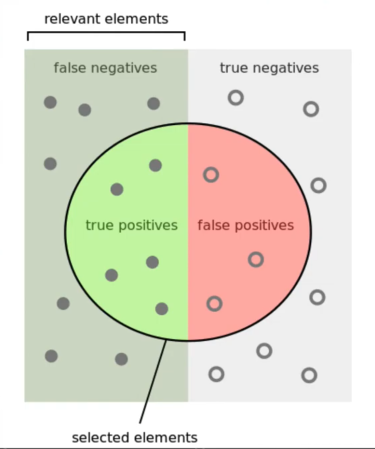
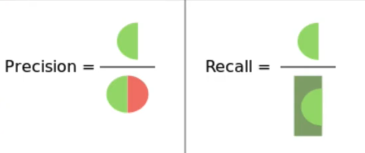

<br> F1 toma en cuenta como están distribuidos los datos, por lo que para unos datos desbalanceados es bueno considerarlo

In [119]:
from sklearn.metrics import f1_score

print(f"svc: {f1_score(test_y, svc.predict(test_x_vector),labels=['positive', 'negative'],average=None)}")
print(f"dec: {f1_score(test_y, dec.predict(test_x_vector),labels=['positive', 'negative'],average=None)}")
print(f"gnb: {f1_score(test_y, gnb.predict(test_x_vector.toarray()),labels=['positive', 'negative'],average=None)}")
print(f"lr: {f1_score(test_y, lr.predict(test_x_vector),labels=['positive', 'negative'],average=None)}")


svc: [0.83309144 0.8177496 ]
dec: [0.67264574 0.66359447]
gnb: [0.6851312  0.65930599]
lr: [0.84040996 0.8288854 ]


## 4.3. Reporte de clasificación
support son los datos que se están usando

In [120]:
from sklearn.metrics import classification_report

print(f"svc: {classification_report(test_y, svc.predict(test_x_vector),labels=['positive', 'negative'])}")
print(f"dec: {classification_report(test_y, dec.predict(test_x_vector),labels=['positive', 'negative'])}")
print(f"gnb: {classification_report(test_y, gnb.predict(test_x_vector.toarray()),labels=['positive', 'negative'])}")
print(f"lr: {classification_report(test_y, lr.predict(test_x_vector),labels=['positive', 'negative'])}")


svc:               precision    recall  f1-score   support

    positive       0.81      0.86      0.83       335
    negative       0.84      0.79      0.82       325

    accuracy                           0.83       660
   macro avg       0.83      0.83      0.83       660
weighted avg       0.83      0.83      0.83       660

dec:               precision    recall  f1-score   support

    positive       0.67      0.67      0.67       335
    negative       0.66      0.66      0.66       325

    accuracy                           0.67       660
   macro avg       0.67      0.67      0.67       660
weighted avg       0.67      0.67      0.67       660

gnb:               precision    recall  f1-score   support

    positive       0.67      0.70      0.69       335
    negative       0.68      0.64      0.66       325

    accuracy                           0.67       660
   macro avg       0.67      0.67      0.67       660
weighted avg       0.67      0.67      0.67       660

lr: 

## 4.4. Confusion Matrix

Esta métrica regresa una matriz de esta forma:

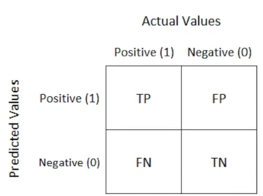

La suma de todos los valores debe ser la cantidad de datos que se predicen<br>

In [121]:
from sklearn.metrics import confusion_matrix

print(f"svc:\n {confusion_matrix(test_y, svc.predict(test_x_vector),labels=['positive', 'negative'])}")
print(f"dec:\n {confusion_matrix(test_y, dec.predict(test_x_vector),labels=['positive', 'negative'])}")
print(f"gnb:\n {confusion_matrix(test_y, gnb.predict(test_x_vector.toarray()),labels=['positive', 'negative'])}")
print(f"lr:\n {confusion_matrix(test_y, lr.predict(test_x_vector),labels=['positive', 'negative'])}")

svc:
 [[287  48]
 [ 67 258]]
dec:
 [[225 110]
 [109 216]]
gnb:
 [[235 100]
 [116 209]]
lr:
 [[287  48]
 [ 61 264]]


# 5 Optimización del modelo

## 5.1 GridSearchCV
Busca cual es el mejor parametro para el modelo

In [122]:
from sklearn.model_selection import GridSearchCV

parameters = {"C":[1, 4, 8, 16, 32], # Cuanto error es soportable
              "kernel":["linear", "rbf"]} # Indica que tipo de función queremos usar

svc = SVC()
svc_grid = GridSearchCV(svc, parameters, cv=5) # cv son la cantidad de cruces
svc_grid.fit(train_x_vector, train_y)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1, 4, 8, 16, 32], 'kernel': ['linear', 'rbf']})

In [123]:
print(svc_grid.best_estimator_)
print(svc_grid.best_params_)

SVC(C=1, kernel='linear')
{'C': 1, 'kernel': 'linear'}


In [124]:
svc_grid.best_score_

0.8305970149253732